In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os, json, random
from scipy import optimize
from scipy.optimize import curve_fit
from numpy import pi, cos, sin, log
import pandas as pd
#from qutip import * 

In [2]:
5*10 + 3 *0.5*2**2

56.0

In [16]:
# effective dielectric constant 
chip_area = 5.650e-3 * 500e-6
hole_area = np.pi * (5.800e-3)**2
chip_dielectric_constant = 11.9

effective_dielectric_constant = (chip_area)/hole_area * chip_dielectric_constant + (1 - (chip_area)/hole_area) * 1.0
print(f"Effective dielectric constant: {effective_dielectric_constant:.2f}")

Effective dielectric constant: 1.29


In [3]:
'''
From equations on the following website
https://www.eeweb.com/tools/edge-coupled-microstrip-impedance/
'''


def ABCD_HL(zhi, f, length, veff):
    ABCD_matrix = np.matrix([[cos(2*pi*f*length/veff), 1j*zhi*sin(2*pi*f*length/veff)], 
                             [1j/zhi*sin(2*pi*f*length/veff), cos(2*pi*f*length/veff)]])
    return ABCD_matrix

def epsilon_re(er, h, W):
    if W >= h:
        return (er+1)/2+(er-1)/2*(1+12*h/W)**(-0.5)
    else:
        return (er+1)/2+(er-1)/2*((1+12*h/W)**(-0.5)+0.04*(1-W/h)**2)

def Zc(ere, W, h):
    '''
    # zo_surface
    '''
    yita = 120*pi    
    if W >= h:
        return yita/np.sqrt(ere)/(W/h+1.393+0.677*log(W/h+1.444))
    else:
        return yita/2/pi/np.sqrt(ere)*log(8*h/W+0.25*W/h)
    

def ero(er, W, s, h):
    ere = epsilon_re(er, h, W)
    u = W/h
    g = s/h
    a0 = 0.7287*(ere-0.5*(er+1))*(1-np.exp(-0.179*u))
    b0 = 0.747*er/(0.15+er)
    c0 = b0-(b0-0.207)*np.exp(-0.414*u)
    d0 = 0.593+0.694*np.exp(-0.526*u)
    ere_o = ere+(0.5*(er+1)-ere+a0)*np.exp(-c0*g**d0)    
    return ere_o

def Zco(er, W, s, h):
    '''
    computes zo_odd
    '''
    u = W/h
    g = s/h
    
    zzc = Zc(er, W, h) # zo_surface
    ere = epsilon_re(er, h, W)
    ere_o = ero(er, W, s, h)
    
    Q1 = 0.8685*u**0.194
    Q2 = 1+0.7519*g+0.189*g**2.31
    Q3 = 0.1975+(16.6+(8.4/g)**6)**(-0.387)+1/241*log(g**10/(1+(g/3.4)**10))
    Q4 = 2*Q1/Q2/(u**Q3*np.exp(-g)+(2-np.exp(-g))*u**(-Q3))    
    Q5 = 1.794+1.14*log(1+0.638/(g+0.517*g**2.43))
    Q6 = 0.2305+1/281.3*log(g**10/(1+(g/5.8)**10))+1/5.1*log(1+0.598*g**1.154)
    Q7 = (10+190*g**2)/(1+82.3*g**3)
    Q8 = np.exp(-6.5-0.95*log(g)-(g/0.15)**5)
    Q9 = log(Q7)*(Q8+1/16.5)
    Q10 = Q4-Q5/Q2*np.exp(Q6*log(u)/u**Q9)
    ZZ = zzc*np.sqrt(ere/ere_o)/(1-Q10*np.sqrt(ere)*zzc/377)
    return ZZ

# Odd mode dielectric constant and impedance
def ae(v):
    '''
    some functuion to help compute er_eff_even
    '''
    output = ( 1 + 
              ( (np.log( (v**4 + (v/52)**2) / (v**4 + 0.432) )) / 49) + 
              ((np.log(1 + (v/18.1)**3)) / 18.7)
        
    )
    return output
    
def be(er):
    '''
    some functuion to help compute er_eff_even
    '''
    output = ( 0.564 * 
              ((er - 0.9) / (er + 3))**0.053
    )
    return output

def ere_even(er, W, s, h):
    '''
    er_effective_e
    '''
    #ere = epsilon_re(er, h, W)
    u = W/h
    g = s/h
    
    v = (( (u * (g**2 + 20 ) ) / (g**2  + 10))
         + 
            (g*np.exp(-1*g)) 
        )
    
    
    ere_even_out = ( 0.5 * (er + 1) + 
                 0.5 * (er - 1) * (1 + 10/v) ** (-1* ae(v) * be(er))
        
    )
    return ere_even_out
    
def Zo_even(er, W, s, h):
    '''
    computes zo_even
    '''
    u = W/h
    g = s/h
    
    zzc = Zc(er, W, h) # zo_surface
    ere = epsilon_re(er, h, W)
    ere_e = ere_even(er, W, s, h)
    nu0 = 377 # ??
    
    Q1 = 0.8685*u**0.194
    Q2 = 1+0.7519*g+0.189*g**2.31
    Q3 = 0.1975+(16.6+(8.4/g)**6)**(-0.387)+1/241*log(g**10/(1+(g/3.4)**10))
    Q4 = 2*Q1/Q2/(u**Q3*np.exp(-g)+(2-np.exp(-g))*u**(-Q3))    
    
    
    ZZ = (zzc * 
         np.sqrt(ere / ere_e) /
          (1 - Q4 * np.sqrt(ere) * zzc / nu0)
         
    )
    return ZZ


# current design

In [32]:

h = 500*1e-6

# Capcitor Pads
w_lo = 2.422e-3#0.8*2.7e-3#1.5e-3#2.3675*1e-3 #2.4225*1e-3 #* 10
s_lo = 3*1e-6#15*1e-6
length_lo = 6.1*1e-3

# Inductor
w_hi = 3*1e-6 
s_hi = 3*1e-6
length_hi = 2.643*2*1e-3#length_lo#0.8*2 * 2.5 * 1e-3#4.5*1e-3#5.8*1e-3


er = 11#1.29
z0 = 50
zlo = Zco(er, w_lo, s_lo, h)
zhi = Zco(er, w_hi, s_hi, h)
erlo = ero(er, w_lo, w_lo, h)
erhi = ero(er, w_hi, w_hi, h)

# zhi = 138.45   # from online calculator
# zlo = 22.91

vlo = 3*10**8/np.sqrt(erlo)
vhi = 3*10**8/np.sqrt(erhi)

# vlo = 1.2*10**8
# vhi = 1.2*10**8

nstep = 1000
f_list = np.linspace(0.1*10**9, 10*10**9, nstep)
S21 = []
for f in f_list:
    ABCDlo = ABCD_HL(zlo, f, length_lo, vlo)
    ABCDhi = ABCD_HL(zhi, f, length_hi, vhi)
    #ABCDhi = ABCD_HL(zhi, f, length_hi, vhi)
    n = 5
    ABCD = ABCD_HL(zhi, f, 2*length_hi, vhi)*ABCDlo
    for i in range(n-1): 
        ABCD *= ABCDhi*ABCDlo
    
    #ABCD = ABCD_HL(zhi, f, 6E-3, vhi) *ABCDlo*ABCDhi*ABCDlo*ABCDhi*ABCDlo*ABCDhi*ABCDlo*ABCDhi*ABCDlo
    ss = 2/(ABCD[0,0]+ABCD[0,1]/z0+ABCD[1,0]*z0+ABCD[1,1])
    S21.append(10*np.log10(abs(ss*ss)))

In [33]:
DCflux = 0.2*np.pi
flux_amp = 0.15*np.pi
cavity = [4.95, 6.75]
operating_freq = 4.4
bare_freq = operating_freq/np.sqrt(np.cos(DCflux))
freq_low = bare_freq*np.sqrt(np.cos(DCflux+flux_amp))
freq_hi = bare_freq*np.sqrt(np.cos(DCflux-flux_amp))

In [34]:
freq_hi

4.861651430972093

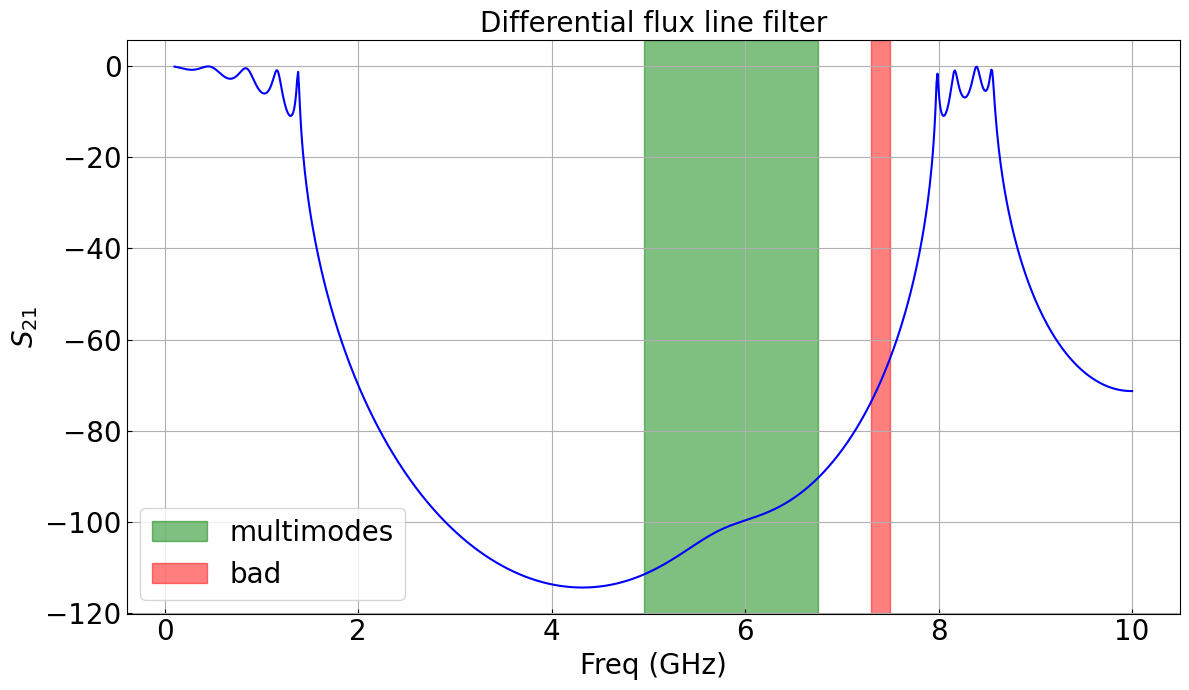

In [35]:
import matplotlib.transforms as mtransforms
fig, ax = plt.subplots(1, 1, figsize=(12,7))
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
plt.plot(f_list/1e9, S21, '-', color='blue')
# plt.axvline(freq_low,  linestyle='--', color = 'r', label = 'Coupler low frequency')
# plt.axvline(freq_hi,  linestyle='--', color = 'b', label = 'Coupler high frequency')
# ax.axvspan(freq_low, freq_hi, alpha=0.5, color='red', label='coupler')
ax.axvspan(cavity[0], cavity[1], alpha=0.5, color='green', label='multimodes')
ax.axvspan(7.3, 7.5, alpha=0.5, color='red', label='bad')

ax.set_xlabel(r'Freq (GHz)',size=20)
ax.set_ylabel(r'$S_{21}$',size=20)
ax.tick_params(labelsize=20)
plt.rcParams['xtick.direction'] = 'in'  
plt.rcParams['ytick.direction'] = 'in'
plt.title(r'Differential flux line filter',size=20)
#plt.yscale('log')
# plt.ylim([3000,14000])
plt.grid()
plt.legend(fontsize=20)
plt.tight_layout()

# From Experimental Data

In [11]:
parent_path = 'G:\Shared drives\multimode\Side Projects\Filter Design\Experiment Data'
file = '\\20240108_ExpData_FluxLineDrivingModes.xlsx'
file_path = parent_path + file

df = pd.read_excel(file_path)

In [12]:
df

,Mode frequency (Ghz),Input Power on Flux line (dB),Peak Power (dB),Background Level (dB)
0,5.868140,-40,-36.00,-70.00
1,6.040050,-40,-47.00,-75.00
2,6.230090,-40,-45.00,-70.00
3,6.408680,-20,-56.67,-60.00
4,6.588686,-20,-59.84,-81.10
5,6.766716,-20,-64.14,-75.98
6,7.146975,-20,-66.00,-90.00


In [13]:
def db_to_voltage_ratio(listy):
    '''
    gain (db) = 20 log( Vout/ Vin)
    '''
    listy = np.array(listy)
    return 10 ** (listy / 20)

def voltage_ratio_to_db(listy):
    '''
    gain (db) = 20 log( Vout/ Vin)
    '''
    listy = np.array(listy)
    return 20 * np.log10(listy)

In [14]:
diff = voltage_ratio_to_db(
    db_to_voltage_ratio(df['Peak Power (dB)']) - db_to_voltage_ratio(df['Background Level (dB)'])
)
df.insert(4, 'Peak-Background', diff)

In [15]:
df

,Mode frequency (Ghz),Input Power on Flux line (dB),Peak Power (dB),Background Level (dB),Peak-Background
0,5.868140,-40,-36.00,-70.00,-36.175059
1,6.040050,-40,-47.00,-75.00,-47.352863
2,6.230090,-40,-45.00,-70.00,-45.502715
3,6.408680,-20,-56.67,-60.00,-66.609272
4,6.588686,-20,-59.84,-81.10,-60.625798
5,6.766716,-20,-64.14,-75.98,-66.706891
6,7.146975,-20,-66.00,-90.00,-66.566096


In [16]:
np.array([1,2,3]) - 1

array([0, 1, 2])

In [17]:
def normalize_list(arry):
    '''
    given numpy array, normalizes it 
    '''
    #floor to 0 
    arry_f = arry - np.min(arry)
    #rescale to 0 and 1
    return arry_f / np.max(arry_f)

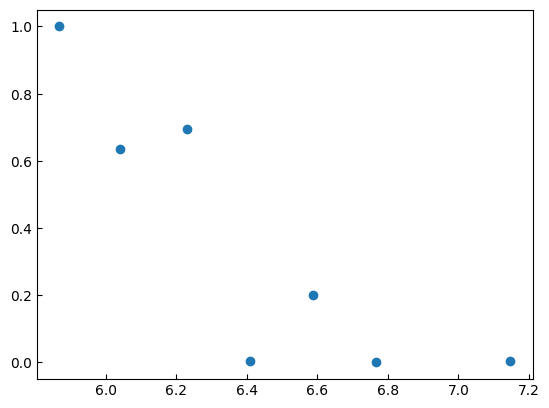

In [18]:
x = list(df['Mode frequency (Ghz)'])
y = list(df['Peak-Background'])

plt.plot(x, normalize_list(y), marker = 'o' , linestyle = ' ',  label = 'Experiment')

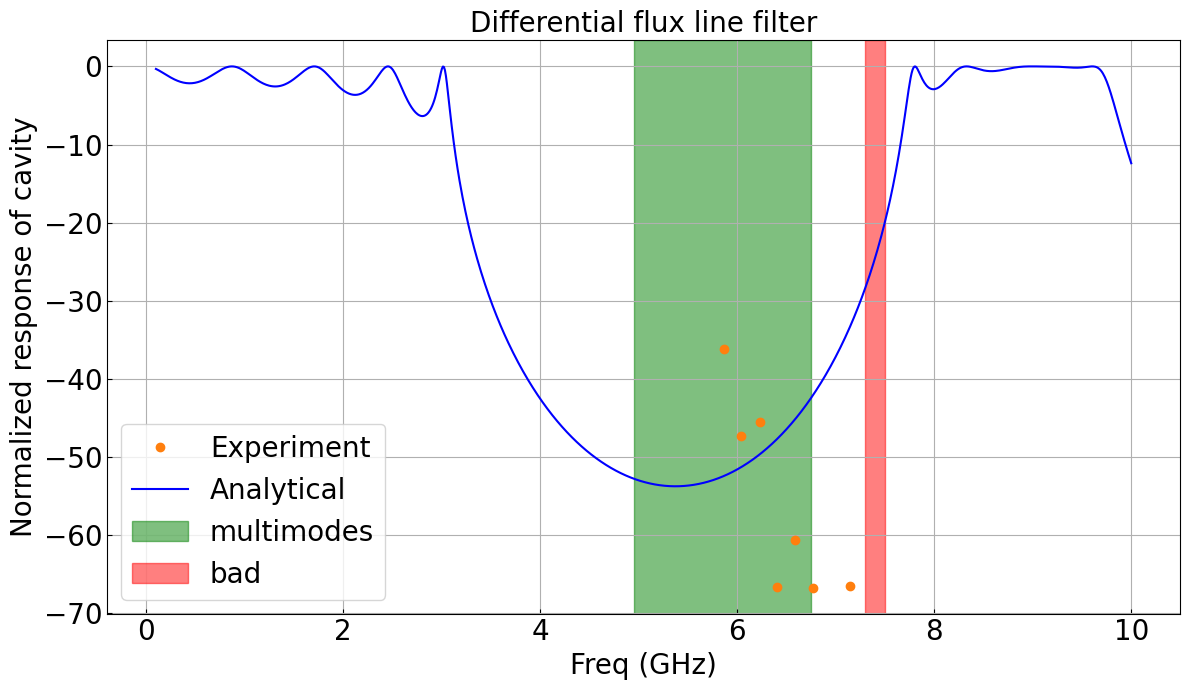

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(12,7))

# Experiment Data
x = list(df['Mode frequency (Ghz)'])
y = list(df['Peak-Background'])

#plt.plot(x, normalize_list(y), marker = 'o' ,color = 'tab:orange', linestyle = ' ',  label = 'Experiment')
plt.plot(x,y, marker = 'o' ,color = 'tab:orange', linestyle = ' ',  label = 'Experiment')

## Sigmulation code
#plt.plot(f_list/1e9, normalize_list(S21), '-', color='blue', label ='Analytical')
plt.plot(f_list/1e9, S21, '-', color='blue', label ='Analytical')
# plt.axvline(freq_low,  linestyle='--', color = 'r', label = 'Coupler low frequency')
# plt.axvline(freq_hi,  linestyle='--', color = 'b', label = 'Coupler high frequency')
# ax.axvspan(freq_low, freq_hi, alpha=0.5, color='red', label='coupler')
ax.axvspan(cavity[0], cavity[1], alpha=0.5, color='green', label='multimodes')
ax.axvspan(7.3, 7.5, alpha=0.5, color='red', label='bad')

ax.set_xlabel(r'Freq (GHz)',size=20)
ax.set_ylabel('Normalized response of cavity',size=20)
ax.tick_params(labelsize=20)
plt.rcParams['xtick.direction'] = 'in'  
plt.rcParams['ytick.direction'] = 'in'
plt.title(r'Differential flux line filter',size=20)
# plt.yscale('log')
# plt.ylim([3000,14000])
plt.grid()
plt.legend(fontsize=20)
plt.tight_layout()

In [20]:
list(df['Mode frequency (Ghz)'])

[5.86814, 6.04005, 6.23009, 6.40868, 6.588686, 6.766716, 7.146975]

# From HFSS Data

In [21]:
parent_path = 'G:\Shared drives\multimode\Side Projects\Filter Design\HFSS Data'
file = '\\20240116_Multimode_filter_discrete.csv'
file_path = parent_path + file

df_hfss = pd.read_csv(file_path)

In [22]:
df_hfss

,Phase [deg],Freq [GHz],abs(SQUID_flux_driven) []
0,0,0.100000,1409.344039
1,0,0.124812,1426.013903
2,0,0.149624,1447.185022
3,0,0.174436,1473.340525
4,0,0.199248,1505.040567
...,...,...,...
395,0,9.900752,94.831374
396,0,9.925564,100.251098
397,0,9.950376,109.914848
398,0,9.975188,111.198034


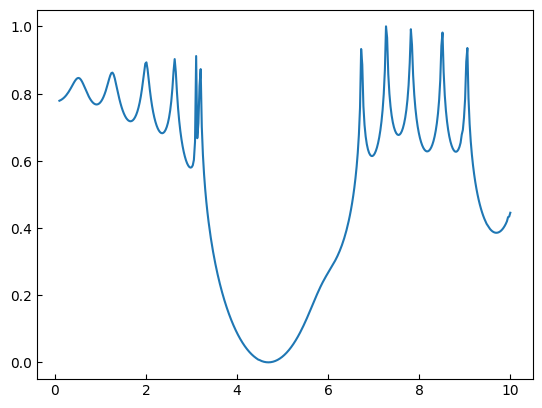

In [23]:
x = list(df_hfss['Freq [GHz]'])
y = list(df_hfss['abs(SQUID_flux_driven) []'])

plt.plot(x, normalize_list(np.log(y)), marker = ' ' , linestyle = '-',  label = 'Experiment')

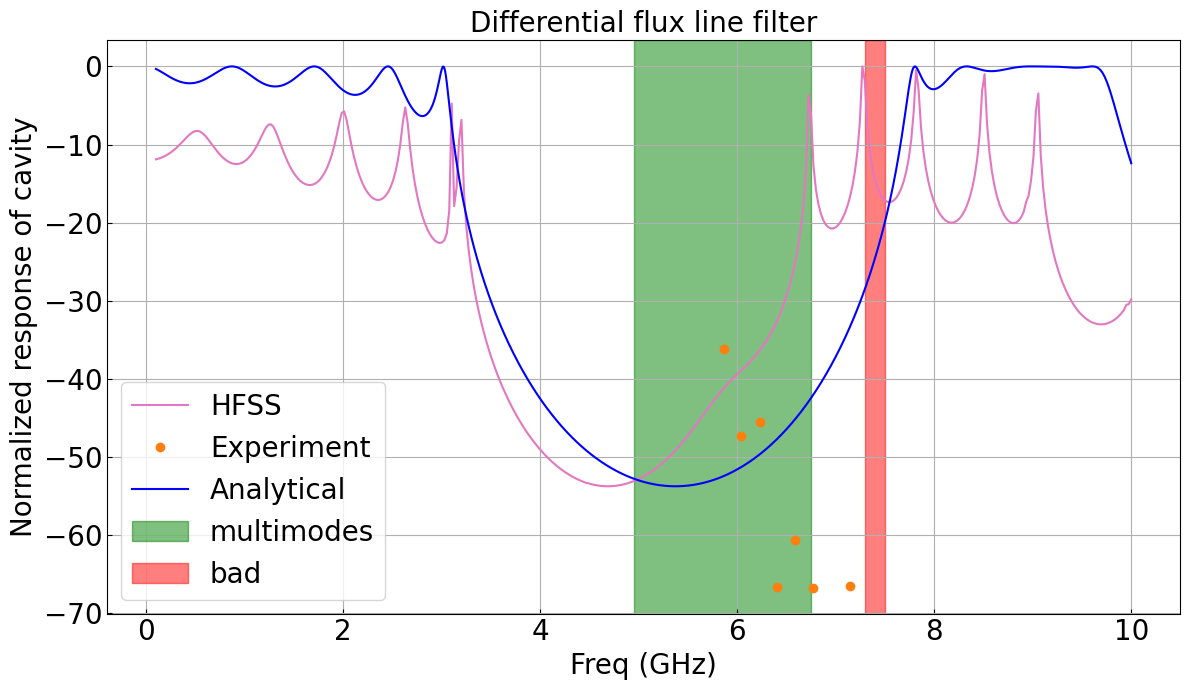

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(12,7))


#HFSS Data
x = list(df_hfss['Freq [GHz]'])
y = list(df_hfss['abs(SQUID_flux_driven) []'])
plt.plot(x, np.abs(np.min(S21)) * normalize_list(np.log(y)) + np.min(S21) , 
         marker = ' ' , color = 'tab:pink', linestyle = '-',  label = 'HFSS')
#plt.plot(x, np.log(y), marker = ' ' , color = 'tab:pink', linestyle = '-',  label = 'HFSS')


# Experiment Data
x = list(df['Mode frequency (Ghz)'])
y = list(df['Peak-Background'])

#plt.plot(x, normalize_list(y), marker = 'o' ,color = 'tab:orange', linestyle = ' ',  label = 'Experiment')
plt.plot(x,y, marker = 'o' ,color = 'tab:orange', linestyle = ' ',  label = 'Experiment')

## Sigmulation code
#plt.plot(f_list/1e9, normalize_list(S21), '-', color='blue', label ='Analytical')
plt.plot(f_list/1e9, S21, '-', color='blue', label ='Analytical')
# plt.axvline(freq_low,  linestyle='--', color = 'r', label = 'Coupler low frequency')
# plt.axvline(freq_hi,  linestyle='--', color = 'b', label = 'Coupler high frequency')
# ax.axvspan(freq_low, freq_hi, alpha=0.5, color='red', label='coupler')
ax.axvspan(cavity[0], cavity[1], alpha=0.5, color='green', label='multimodes')
ax.axvspan(7.3, 7.5, alpha=0.5, color='red', label='bad')

ax.set_xlabel(r'Freq (GHz)',size=20)
ax.set_ylabel('Normalized response of cavity',size=20)
ax.tick_params(labelsize=20)
plt.rcParams['xtick.direction'] = 'in'  
plt.rcParams['ytick.direction'] = 'in'
plt.title(r'Differential flux line filter',size=20)
# plt.yscale('log')
# plt.ylim([3000,14000])
plt.grid()
plt.legend(fontsize=20)
plt.tight_layout()

# From HFSS Data with package

In [25]:
parent_path = 'G:\Shared drives\multimode\Side Projects\Filter Design\HFSS Data'
file = '\\20240119_filter_package.csv'
file_path = parent_path + file

df_hfss_pack = pd.read_csv(file_path)

In [26]:
df_hfss_pack

,Phase [deg],Freq [GHz],abs(SQUID_flux_driven) []
0,0,2.953383,904.967733
1,0,2.978195,727.477090
2,0,3.003008,578.877717
3,0,3.027820,473.232456
4,0,3.052632,398.814729
...,...,...,...
280,0,9.900752,790.605345
281,0,9.925564,738.691694
282,0,9.950376,701.454195
283,0,9.975188,675.532157


In [27]:
df_hfss_pack['Freq [GHz]'][100:]

100     5.434586
101     5.459398
102     5.484211
103     5.509023
104     5.533835
         ...    
280     9.900752
281     9.925564
282     9.950376
283     9.975188
284    10.000000
Name: Freq [GHz], Length: 185, dtype: float64

In [28]:
df_hfss_pack['abs(SQUID_flux_driven) []'][100:]

100     14.370755
101      9.864432
102      7.127189
103      5.272723
104      4.246931
          ...    
280    790.605345
281    738.691694
282    701.454195
283    675.532157
284    658.889535
Name: abs(SQUID_flux_driven) [], Length: 185, dtype: float64

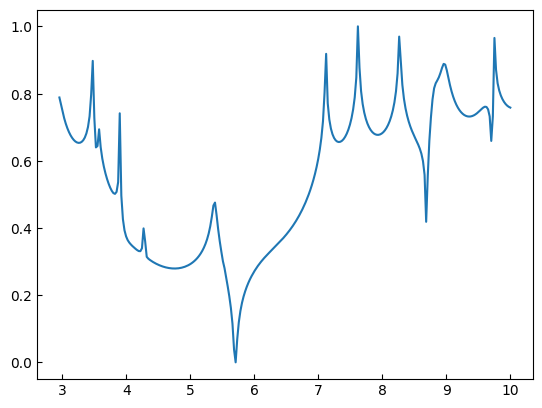

In [29]:
x = list(df_hfss_pack['Freq [GHz]'])
y = list(df_hfss_pack['abs(SQUID_flux_driven) []'])

plt.plot(x, normalize_list(np.log(y)), marker = ' ' , linestyle = '-',  label = 'Experiment')

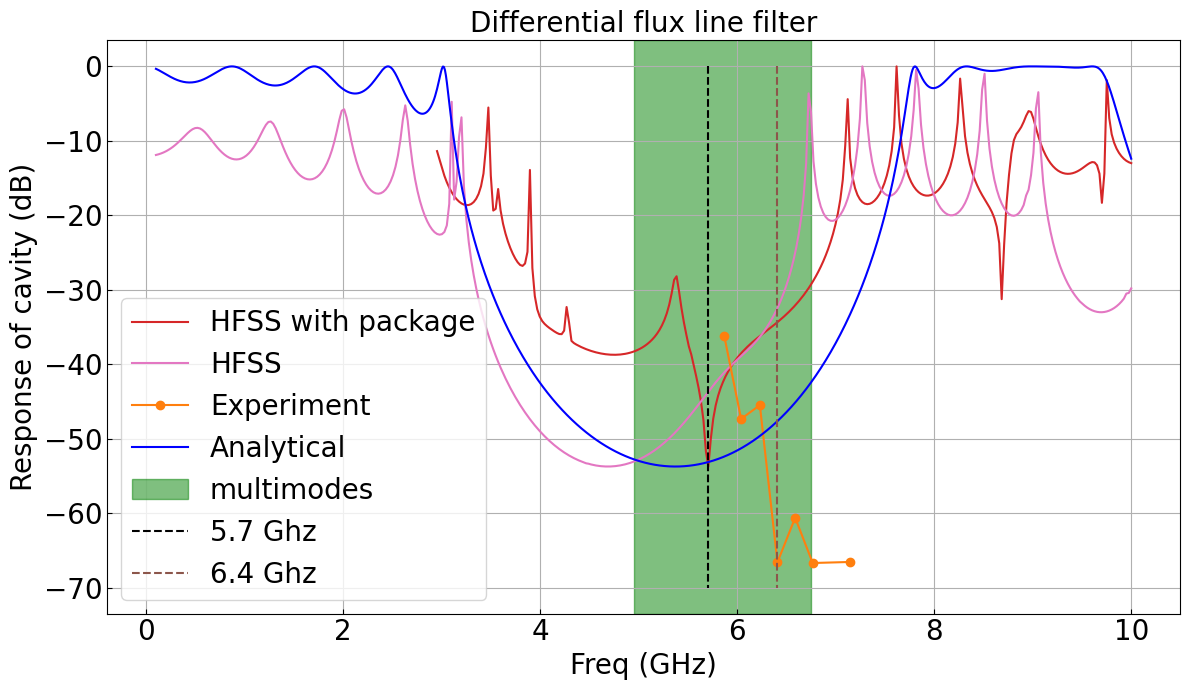

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(12,7))

#HFSS Data with package
x = list(df_hfss_pack['Freq [GHz]'])
y = list(df_hfss_pack['abs(SQUID_flux_driven) []'])
plt.plot(x, np.abs(np.min(S21)) * normalize_list(np.log(y)) + np.min(S21),
         marker = ' ' , color = 'tab:red', linestyle = '-',  label = 'HFSS with package')



#HFSS Data
x = list(df_hfss['Freq [GHz]'])
y = list(df_hfss['abs(SQUID_flux_driven) []'])
plt.plot(x, np.abs(np.min(S21)) * normalize_list(np.log(y)) + np.min(S21) , 
         marker = ' ' , color = 'tab:pink', linestyle = '-',  label = 'HFSS')
#plt.plot(x, np.log(y), marker = ' ' , color = 'tab:pink', linestyle = '-',  label = 'HFSS')


# Experiment Data
x = list(df['Mode frequency (Ghz)'])
y = list(df['Peak-Background'])

#plt.plot(x, normalize_list(y), marker = 'o' ,color = 'tab:orange', linestyle = ' ',  label = 'Experiment')
plt.plot(x,y, marker = 'o' ,color = 'tab:orange', linestyle = '-',  label = 'Experiment')

## Sigmulation code
#plt.plot(f_list/1e9, normalize_list(S21), '-', color='blue', label ='Analytical')
plt.plot(f_list/1e9, S21, '-', color='blue', label ='Analytical')
# plt.axvline(freq_low,  linestyle='--', color = 'r', label = 'Coupler low frequency')
# plt.axvline(freq_hi,  linestyle='--', color = 'b', label = 'Coupler high frequency')
# ax.axvspan(freq_low, freq_hi, alpha=0.5, color='red', label='coupler')
ax.axvspan(cavity[0], cavity[1], alpha=0.5, color='green', label='multimodes')
#ax.axvspan(7.3, 7.5, alpha=0.5, color='red', label='bad')

plt.vlines(5.7,0, -70, color = 'k', linestyle = '--', label = '5.7 Ghz')
plt.vlines(6.4,0, -70, color = 'tab:brown', linestyle = '--', label = '6.4 Ghz')

ax.set_xlabel(r'Freq (GHz)',size=20)
ax.set_ylabel('Response of cavity (dB)',size=20)
ax.tick_params(labelsize=20)
plt.rcParams['xtick.direction'] = 'in'  
plt.rcParams['ytick.direction'] = 'in'
plt.title(r'Differential flux line filter',size=20)
# plt.yscale('log')
# plt.ylim([3000,14000])
plt.grid()
plt.legend(fontsize=20)
plt.tight_layout()

In [31]:
#Zooming in on spiky region
parent_path = 'G:\Shared drives\multimode\Side Projects\Filter Design\HFSS Data'
file = '\\20240122_filter_with_package_finer.csv'
file_path = parent_path + file

df_hfss_pack_finer = pd.read_csv(file_path)
df_hfss_pack_finer

,Phase [deg],Freq [GHz],abs(SQUID_flux_driven) []
0,0,5.230000,8.524898
1,0,5.231906,8.606850
2,0,5.233813,8.690624
3,0,5.235719,8.776702
4,0,5.237625,8.864910
...,...,...,...
295,0,5.792375,1.190351
296,0,5.794281,1.213705
297,0,5.796187,1.236960
298,0,5.798094,1.260180


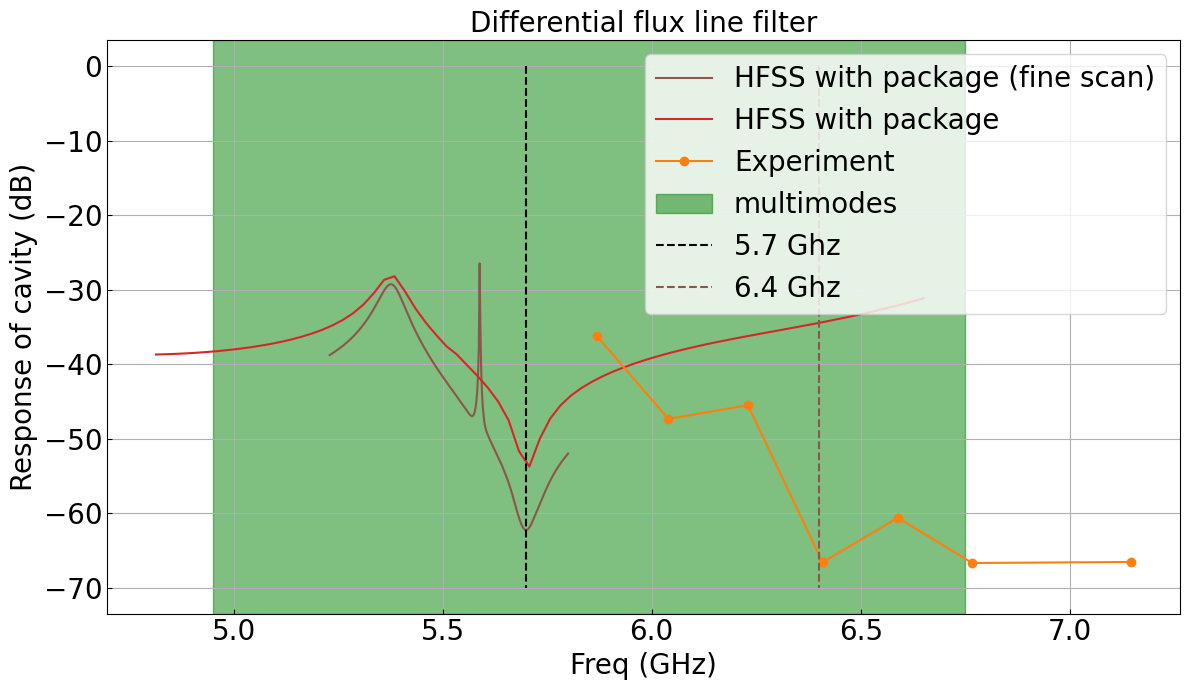

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(12,7))

#HFSS Data with package
x = list(df_hfss_pack_finer['Freq [GHz]'])
y = list(df_hfss_pack_finer['abs(SQUID_flux_driven) []'])
plt.plot(x, np.abs(np.min(S21)) * 0.13 *np.log(y) + np.min(S21),
         marker = ' ' , color = 'tab:brown', linestyle = '-',  label = 'HFSS with package (fine scan)')

#HFSS Data with package
i = 75
j = 150
x = list(df_hfss_pack['Freq [GHz]'])
y = list(df_hfss_pack['abs(SQUID_flux_driven) []'])
plt.plot(x[i:j], np.abs(np.min(S21)) * normalize_list(np.log(y))[i:j] + np.min(S21),
         marker = ' ' , color = 'tab:red', linestyle = '-',  label = 'HFSS with package')



# #HFSS Data
# x = list(df_hfss['Freq [GHz]'])
# y = list(df_hfss['abs(SQUID_flux_driven) []'])
# plt.plot(x, np.abs(np.min(S21)) * normalize_list(np.log(y)) + np.min(S21) , 
#          marker = ' ' , color = 'tab:pink', linestyle = '-',  label = 'HFSS')
# #plt.plot(x, np.log(y), marker = ' ' , color = 'tab:pink', linestyle = '-',  label = 'HFSS')


# Experiment Data
x = list(df['Mode frequency (Ghz)'])
y = list(df['Peak-Background'])

#plt.plot(x, normalize_list(y), marker = 'o' ,color = 'tab:orange', linestyle = ' ',  label = 'Experiment')
plt.plot(x,y, marker = 'o' ,color = 'tab:orange', linestyle = '-',  label = 'Experiment')

## Sigmulation code
#plt.plot(f_list/1e9, normalize_list(S21), '-', color='blue', label ='Analytical')
#plt.plot(f_list/1e9, S21, '-', color='blue', label ='Analytical')
# plt.axvline(freq_low,  linestyle='--', color = 'r', label = 'Coupler low frequency')
# plt.axvline(freq_hi,  linestyle='--', color = 'b', label = 'Coupler high frequency')
# ax.axvspan(freq_low, freq_hi, alpha=0.5, color='red', label='coupler')
ax.axvspan(cavity[0], cavity[1], alpha=0.5, color='green', label='multimodes')
#ax.axvspan(7.3, 7.5, alpha=0.5, color='red', label='bad')

plt.vlines(5.7,0, -70, color = 'k', linestyle = '--', label = '5.7 Ghz')
plt.vlines(6.4,0, -70, color = 'tab:brown', linestyle = '--', label = '6.4 Ghz')

ax.set_xlabel(r'Freq (GHz)',size=20)
ax.set_ylabel('Response of cavity (dB)',size=20)
ax.tick_params(labelsize=20)
plt.rcParams['xtick.direction'] = 'in'  
plt.rcParams['ytick.direction'] = 'in'
plt.title(r'Differential flux line filter',size=20)
# plt.yscale('log')
# plt.ylim([3000,14000])
plt.grid()
plt.legend(fontsize=20)
plt.tight_layout()

# New Ground

In [33]:
parent_path = 'G:\Shared drives\multimode\Side Projects\Filter Design\HFSS Data'
file = '\\20240126_filter_with_neo_ground.csv'
file_path = parent_path + file

df_hfss_new_ground_pack = pd.read_csv(file_path)

In [34]:
parent_path = 'G:\Shared drives\multimode\Side Projects\Filter Design\HFSS Data'
file = '\\20240126_filter_with_neo_ground_no_package.csv'
file_path = parent_path + file

df_hfss_new_ground = pd.read_csv(file_path)

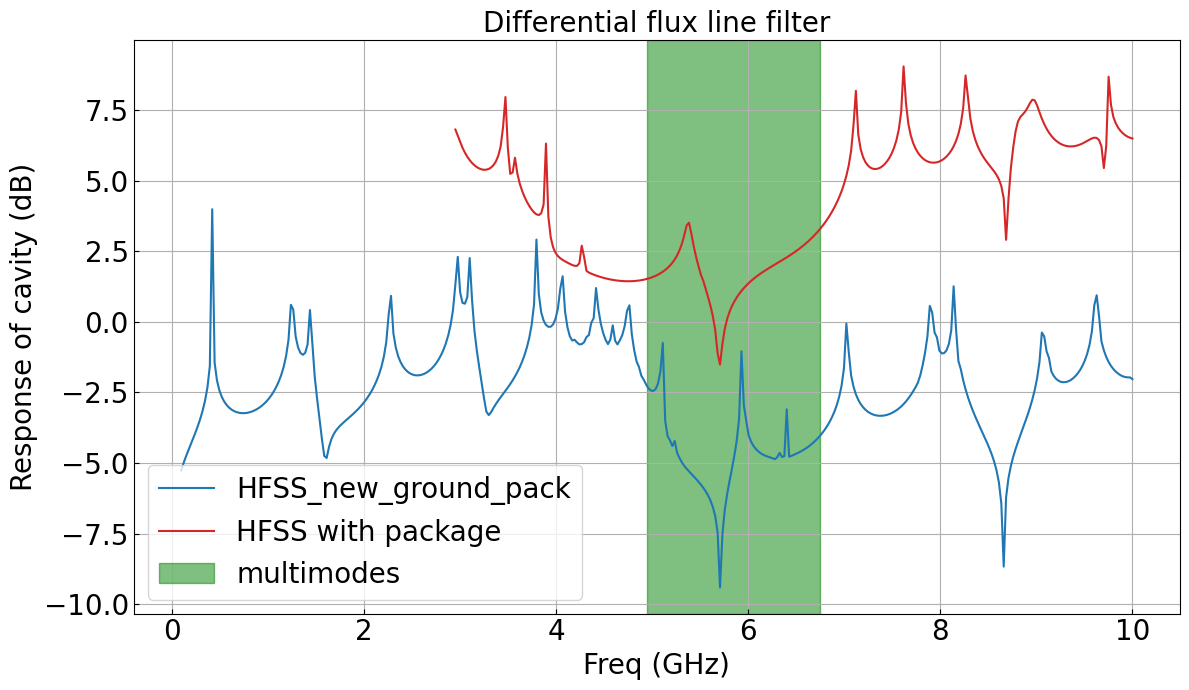

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(12,7))

##With new ground
#HFSS Data with package
x = list(df_hfss_new_ground_pack['Freq [GHz]'])
y = list(df_hfss_new_ground_pack['abs(SQUID_flux_driven) []'])
plt.plot(x, np.log(y),#np.abs(np.min(S21)) * normalize_list(np.log(y)) + np.min(S21) , 
         marker = ' ' , color = 'tab:blue', linestyle = '-',  label = 'HFSS_new_ground_pack')
#plt.plot(x, np.log(y), marker = ' ' , color = 'tab:pink', linestyle = '-',  label = 'HFSS')


# #HFSS Data
# x = list(df_hfss_new_ground['Freq [GHz]'])
# y = list(df_hfss_new_ground['abs(SQUID_flux_driven) []'])
# plt.plot(x, np.log(y),#np.abs(np.min(S21)) * normalize_list(np.log(y)) + np.min(S21) , 
#          marker = ' ' , color = 'tab:purple', linestyle = '-',  label = 'HFSS_new_ground')
# #plt.plot(x, np.log(y), marker = ' ' , color = 'tab:pink', linestyle = '-',  label = 'HFSS')



#HFSS Data with package
x = list(df_hfss_pack['Freq [GHz]'])
y = list(df_hfss_pack['abs(SQUID_flux_driven) []'])
plt.plot(x, np.log(y),#np.abs(np.min(S21)) * normalize_list(np.log(y)) + np.min(S21),
         marker = ' ' , color = 'tab:red', linestyle = '-',  label = 'HFSS with package')



# #HFSS Data
# x = list(df_hfss['Freq [GHz]'])
# y = list(df_hfss['abs(SQUID_flux_driven) []'])
# plt.plot(x, np.log(y),#np.abs(np.min(S21)) * normalize_list(np.log(y)) + np.min(S21) , 
#          marker = ' ' , color = 'tab:pink', linestyle = '-',  label = 'HFSS')
# #plt.plot(x, np.log(y), marker = ' ' , color = 'tab:pink', linestyle = '-',  label = 'HFSS')


# # Experiment Data
# x = list(df['Mode frequency (Ghz)'])
# y = list(df['Peak-Background'])

# #plt.plot(x, normalize_list(y), marker = 'o' ,color = 'tab:orange', linestyle = ' ',  label = 'Experiment')
# plt.plot(x,y, marker = 'o' ,color = 'tab:orange', linestyle = '-',  label = 'Experiment')

## Sigmulation code
#plt.plot(f_list/1e9, normalize_list(S21), '-', color='blue', label ='Analytical')
#plt.plot(f_list/1e9, S21, '-', color='blue', label ='Analytical')
# plt.axvline(freq_low,  linestyle='--', color = 'r', label = 'Coupler low frequency')
# plt.axvline(freq_hi,  linestyle='--', color = 'b', label = 'Coupler high frequency')
# ax.axvspan(freq_low, freq_hi, alpha=0.5, color='red', label='coupler')
ax.axvspan(cavity[0], cavity[1], alpha=0.5, color='green', label='multimodes')
#ax.axvspan(7.3, 7.5, alpha=0.5, color='red', label='bad')

#plt.vlines(5.7,0, -70, color = 'k', linestyle = '--', label = '5.7 Ghz')
#plt.vlines(6.4,0, -70, color = 'tab:brown', linestyle = '--', label = '6.4 Ghz')

ax.set_xlabel(r'Freq (GHz)',size=20)
ax.set_ylabel('Response of cavity (dB)',size=20)
ax.tick_params(labelsize=20)
plt.rcParams['xtick.direction'] = 'in'  
plt.rcParams['ytick.direction'] = 'in'
plt.title(r'Differential flux line filter',size=20)
# plt.yscale('log')
# plt.ylim([3000,14000])
plt.grid()
plt.legend(fontsize=20)
plt.tight_layout()

# Larger New Ground

In [36]:
parent_path = 'G:\Shared drives\multimode\Side Projects\Filter Design\HFSS Data'
file = '\\20240130_filter_with_new_ground.csv'
file_path = parent_path + file

df_hfss_large_new_ground_pack = pd.read_csv(file_path)

In [37]:
parent_path = 'G:\Shared drives\multimode\Side Projects\Filter Design\HFSS Data'
file = '\\20240130_3_section_filter_with_new_ground.csv'
file_path = parent_path + file

df_hfss_large_new_ground_3sec = pd.read_csv(file_path)

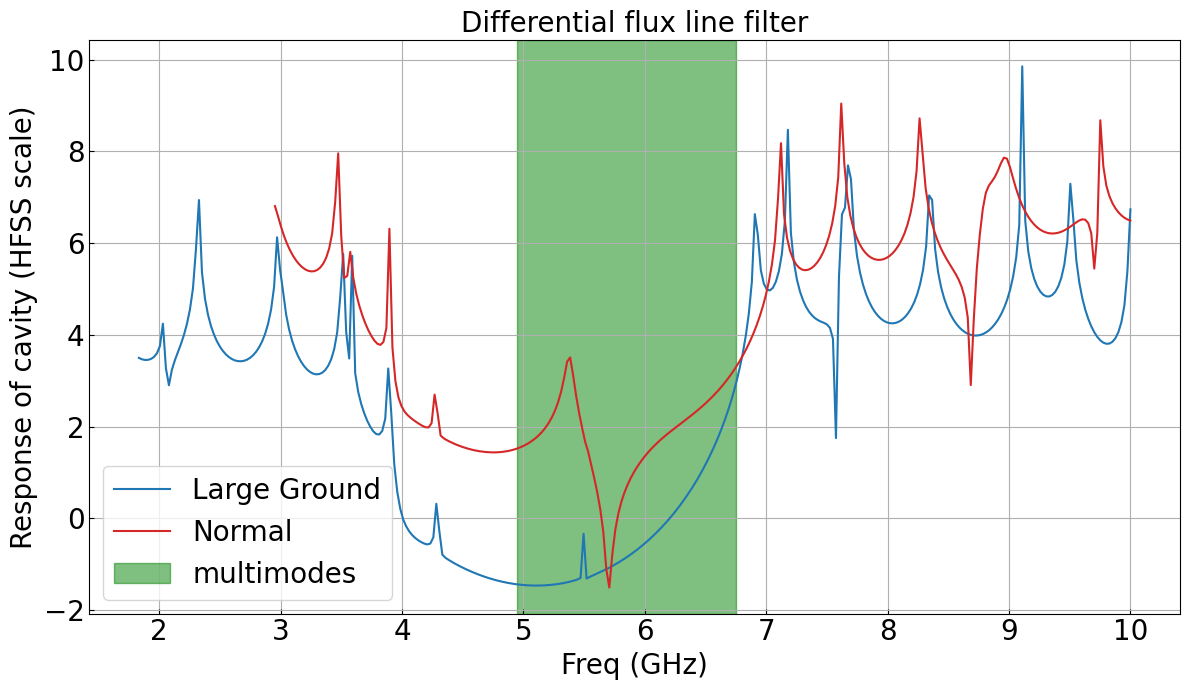

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(12,7))

##With new ground
#HFSS Data with package
x = list(df_hfss_large_new_ground_pack['Freq [GHz]'])
y = list(df_hfss_large_new_ground_pack['abs(SQUID_flux_driven) []'])
plt.plot(x, np.log(y),#np.abs(np.min(S21)) * normalize_list(np.log(y)) + np.min(S21) , 
         marker = ' ' , color = 'tab:blue', linestyle = '-',  label = 'Large Ground')
#plt.plot(x, np.log(y), marker = ' ' , color = 'tab:pink', linestyle = '-',  label = 'HFSS')


# #HFSS Data
# x = list(df_hfss_new_ground['Freq [GHz]'])
# y = list(df_hfss_new_ground['abs(SQUID_flux_driven) []'])
# plt.plot(x, np.log(y),#np.abs(np.min(S21)) * normalize_list(np.log(y)) + np.min(S21) , 
#          marker = ' ' , color = 'tab:purple', linestyle = '-',  label = 'HFSS_new_ground')
# #plt.plot(x, np.log(y), marker = ' ' , color = 'tab:pink', linestyle = '-',  label = 'HFSS')



#HFSS Data with package
x = list(df_hfss_pack['Freq [GHz]'])
y = list(df_hfss_pack['abs(SQUID_flux_driven) []'])
plt.plot(x, np.log(y),#np.abs(np.min(S21)) * normalize_list(np.log(y)) + np.min(S21),
         marker = ' ' , color = 'tab:red', linestyle = '-',  label = 'Normal')



# #HFSS Data
# x = list(df_hfss['Freq [GHz]'])
# y = list(df_hfss['abs(SQUID_flux_driven) []'])
# plt.plot(x, np.log(y),#np.abs(np.min(S21)) * normalize_list(np.log(y)) + np.min(S21) , 
#          marker = ' ' , color = 'tab:pink', linestyle = '-',  label = 'HFSS')
# #plt.plot(x, np.log(y), marker = ' ' , color = 'tab:pink', linestyle = '-',  label = 'HFSS')


# # Experiment Data
# x = list(df['Mode frequency (Ghz)'])
# y = list(df['Peak-Background'])

# #plt.plot(x, normalize_list(y), marker = 'o' ,color = 'tab:orange', linestyle = ' ',  label = 'Experiment')
# plt.plot(x,y, marker = 'o' ,color = 'tab:orange', linestyle = '-',  label = 'Experiment')

## Sigmulation code
#plt.plot(f_list/1e9, normalize_list(S21), '-', color='blue', label ='Analytical')
#plt.plot(f_list/1e9, S21, '-', color='blue', label ='Analytical')
# plt.axvline(freq_low,  linestyle='--', color = 'r', label = 'Coupler low frequency')
# plt.axvline(freq_hi,  linestyle='--', color = 'b', label = 'Coupler high frequency')
# ax.axvspan(freq_low, freq_hi, alpha=0.5, color='red', label='coupler')
ax.axvspan(cavity[0], cavity[1], alpha=0.5, color='green', label='multimodes')
#ax.axvspan(7.3, 7.5, alpha=0.5, color='red', label='bad')

#plt.vlines(5.7,0, -70, color = 'k', linestyle = '--', label = '5.7 Ghz')
#plt.vlines(6.4,0, -70, color = 'tab:brown', linestyle = '--', label = '6.4 Ghz')

ax.set_xlabel(r'Freq (GHz)',size=20)
ax.set_ylabel('Response of cavity (HFSS scale)',size=20)
ax.tick_params(labelsize=20)
plt.rcParams['xtick.direction'] = 'in'  
plt.rcParams['ytick.direction'] = 'in'
plt.title(r'Differential flux line filter',size=20)
# plt.yscale('log')
# plt.ylim([3000,14000])
plt.grid()
plt.legend(fontsize=20)
plt.tight_layout()

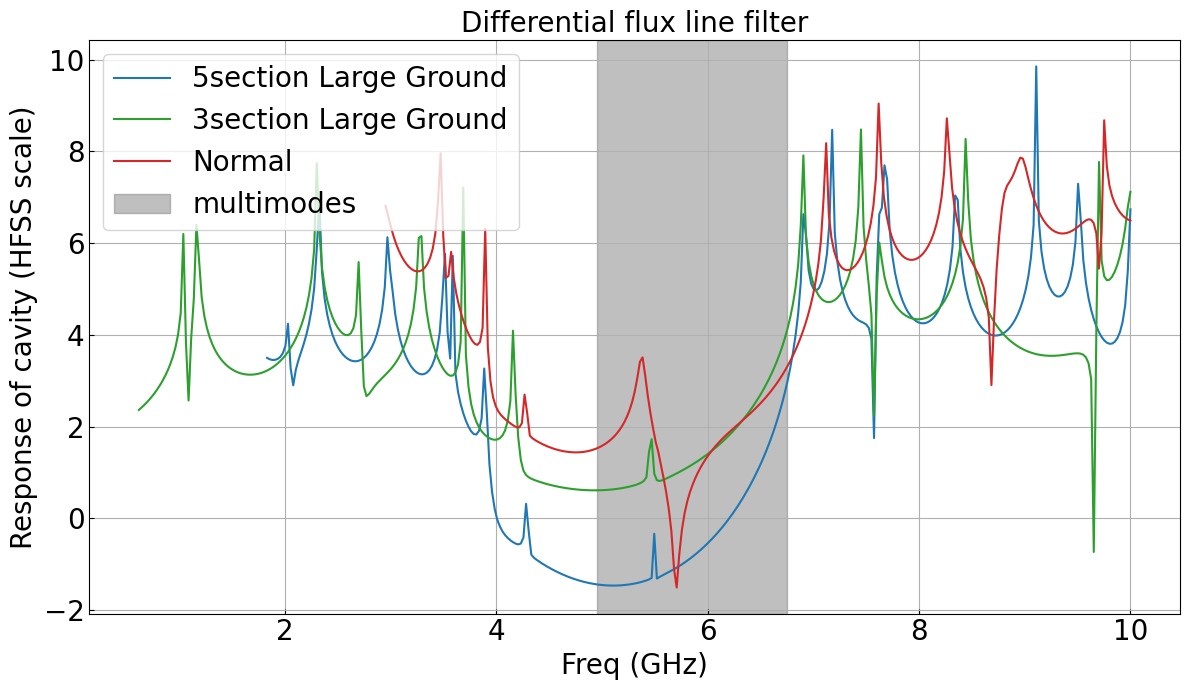

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(12,7))

##With new ground
#HFSS Data with package
x = list(df_hfss_large_new_ground_pack['Freq [GHz]'])
y = list(df_hfss_large_new_ground_pack['abs(SQUID_flux_driven) []'])
plt.plot(x, np.log(y),#np.abs(np.min(S21)) * normalize_list(np.log(y)) + np.min(S21) , 
         marker = ' ' , color = 'tab:blue', linestyle = '-',  label = '5section Large Ground')
#plt.plot(x, np.log(y), marker = ' ' , color = 'tab:pink', linestyle = '-',  label = 'HFSS')

x = list(df_hfss_large_new_ground_3sec['Freq [GHz]'])
y = list(df_hfss_large_new_ground_3sec['abs(SQUID_flux_driven) []'])
plt.plot(x, np.log(y),#np.abs(np.min(S21)) * normalize_list(np.log(y)) + np.min(S21) , 
         marker = ' ' , color = 'tab:green', linestyle = '-',  label = '3section Large Ground')


# #HFSS Data
# x = list(df_hfss_new_ground['Freq [GHz]'])
# y = list(df_hfss_new_ground['abs(SQUID_flux_driven) []'])
# plt.plot(x, np.log(y),#np.abs(np.min(S21)) * normalize_list(np.log(y)) + np.min(S21) , 
#          marker = ' ' , color = 'tab:purple', linestyle = '-',  label = 'HFSS_new_ground')
# #plt.plot(x, np.log(y), marker = ' ' , color = 'tab:pink', linestyle = '-',  label = 'HFSS')



#HFSS Data with package
x = list(df_hfss_pack['Freq [GHz]'])
y = list(df_hfss_pack['abs(SQUID_flux_driven) []'])
plt.plot(x, np.log(y),#np.abs(np.min(S21)) * normalize_list(np.log(y)) + np.min(S21),
         marker = ' ' , color = 'tab:red', linestyle = '-',  label = 'Normal')



# #HFSS Data
# x = list(df_hfss['Freq [GHz]'])
# y = list(df_hfss['abs(SQUID_flux_driven) []'])
# plt.plot(x, np.log(y),#np.abs(np.min(S21)) * normalize_list(np.log(y)) + np.min(S21) , 
#          marker = ' ' , color = 'tab:pink', linestyle = '-',  label = 'HFSS')
# #plt.plot(x, np.log(y), marker = ' ' , color = 'tab:pink', linestyle = '-',  label = 'HFSS')


# # Experiment Data
# x = list(df['Mode frequency (Ghz)'])
# y = list(df['Peak-Background'])

# #plt.plot(x, normalize_list(y), marker = 'o' ,color = 'tab:orange', linestyle = ' ',  label = 'Experiment')
# plt.plot(x,y, marker = 'o' ,color = 'tab:orange', linestyle = '-',  label = 'Experiment')

## Sigmulation code
#plt.plot(f_list/1e9, normalize_list(S21), '-', color='blue', label ='Analytical')
#plt.plot(f_list/1e9, S21, '-', color='blue', label ='Analytical')
# plt.axvline(freq_low,  linestyle='--', color = 'r', label = 'Coupler low frequency')
# plt.axvline(freq_hi,  linestyle='--', color = 'b', label = 'Coupler high frequency')
# ax.axvspan(freq_low, freq_hi, alpha=0.5, color='red', label='coupler')
ax.axvspan(cavity[0], cavity[1], alpha=0.5, color='gray', label='multimodes')
#ax.axvspan(7.3, 7.5, alpha=0.5, color='red', label='bad')

#plt.vlines(5.7,0, -70, color = 'k', linestyle = '--', label = '5.7 Ghz')
#plt.vlines(6.4,0, -70, color = 'tab:brown', linestyle = '--', label = '6.4 Ghz')

ax.set_xlabel(r'Freq (GHz)',size=20)
ax.set_ylabel('Response of cavity (HFSS scale)',size=20)
ax.tick_params(labelsize=20)
plt.rcParams['xtick.direction'] = 'in'  
plt.rcParams['ytick.direction'] = 'in'
plt.title(r'Differential flux line filter',size=20)
# plt.yscale('log')
# plt.ylim([3000,14000])
plt.grid()
plt.legend(fontsize=20)
plt.tight_layout()

# Effect of Package

In [40]:
parent_path = 'G:\Shared drives\multimode\Side Projects\Filter Design\HFSS Data'

In [41]:
file = '\\20240202_filter_proper_package.csv'
file_path = parent_path + file

df_proper_package = pd.read_csv(file_path)

In [42]:
file = '\\20240202_filter_package_inset.csv'
file_path = parent_path + file

df_inset_package = pd.read_csv(file_path)

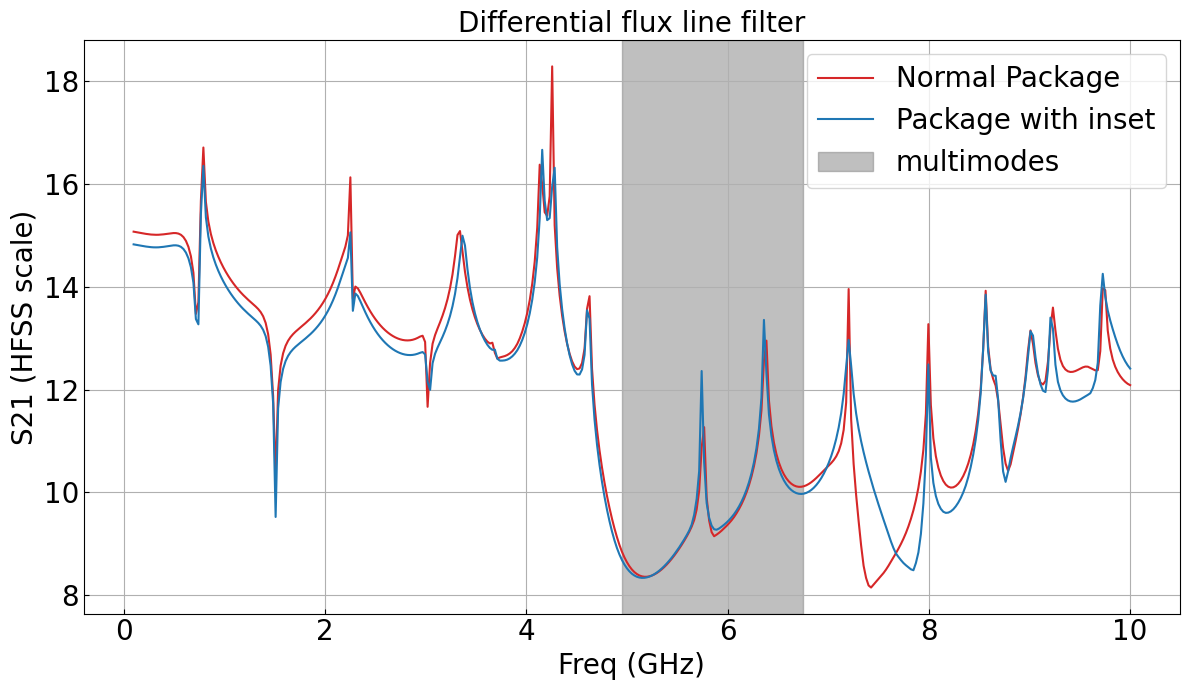

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(12,7))

#normal package
x = list(df_proper_package['Freq [GHz]'])
y = list(df_proper_package['abs(SQUID_flux_driven) []'])
plt.plot(x, np.log(y),#np.abs(np.min(S21)) * normalize_list(np.log(y)) + np.min(S21) , 
         marker = ' ' , color = 'tab:red', linestyle = '-',  label = 'Normal Package')


#Inset package
x = list(df_inset_package ['Freq [GHz]'])
y = list(df_inset_package ['abs(SQUID_flux_driven) []'])
plt.plot(x, np.log(y),#np.abs(np.min(S21)) * normalize_list(np.log(y)) + np.min(S21),
         marker = ' ' , color = 'tab:blue', linestyle = '-',  label = 'Package with inset')


# #Just wirebonds
# x = list(df_hfss_pack['Freq [GHz]'])
# y = list(df_hfss_pack['abs(SQUID_flux_driven) []'])
# plt.plot(x, np.log(y),#np.abs(np.min(S21)) * normalize_list(np.log(y)) + np.min(S21),
#          marker = ' ' , color = 'tab:red', linestyle = '-',  label = 'HFSS with package')


ax.axvspan(cavity[0], cavity[1], alpha=0.5, color='gray', label='multimodes')
#ax.axvspan(7.3, 7.5, alpha=0.5, color='red', label='bad')

#plt.vlines(5.7,0, -70, color = 'k', linestyle = '--', label = '5.7 Ghz')
#plt.vlines(6.4,0, -70, color = 'tab:brown', linestyle = '--', label = '6.4 Ghz')

ax.set_xlabel(r'Freq (GHz)',size=20)
ax.set_ylabel('S21 (HFSS scale)',size=20)
ax.tick_params(labelsize=20)
plt.rcParams['xtick.direction'] = 'in'  
plt.rcParams['ytick.direction'] = 'in'
plt.title(r'Differential flux line filter',size=20)
# plt.yscale('log')
# plt.ylim([3000,14000])
plt.grid()
plt.legend(fontsize=20)
plt.tight_layout()

# Simpler Filter Balun effect

In [44]:
file = '\\20240206_simple_filter_balun.csv'
file_path = parent_path + file
df_simple_filter_balun = pd.read_csv(file_path)

In [45]:
file = '\\20240206_simple_filter_wirebonds.csv'
file_path = parent_path + file

df_simple_filter_wirebonds = pd.read_csv(file_path)

In [46]:
file = '\\20240206_simple_filter_no_package.csv'
file_path = parent_path + file

df_simple_filter_no_pack = pd.read_csv(file_path)

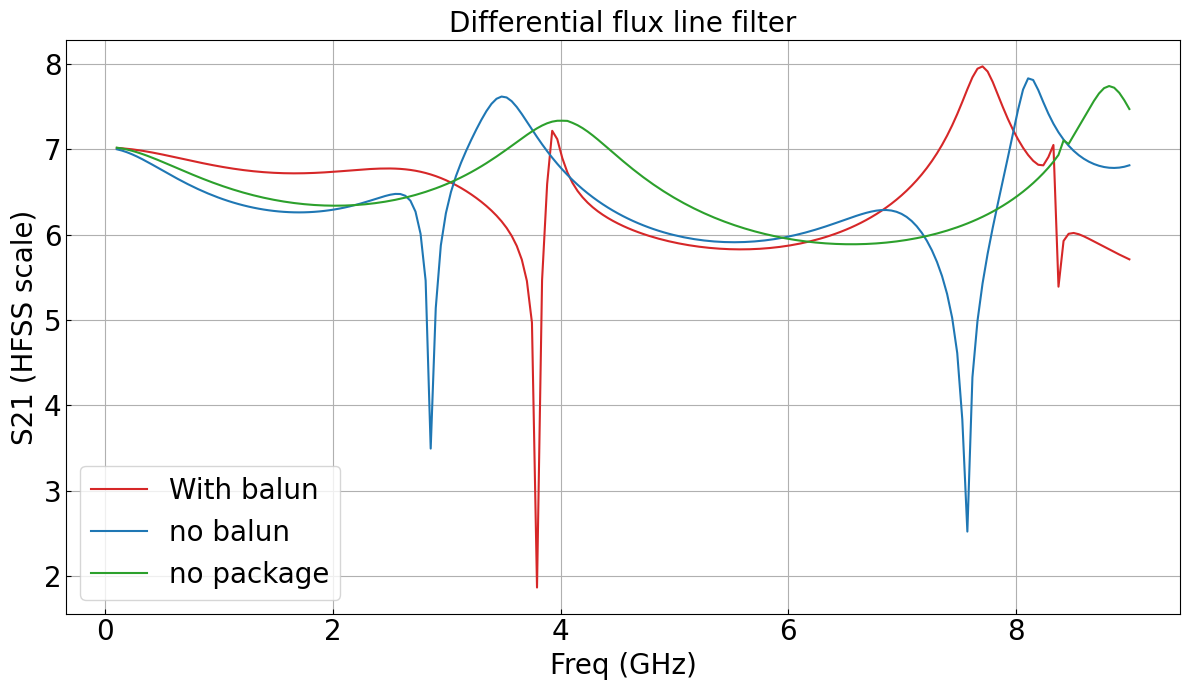

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(12,7))


x = list(df_simple_filter_balun['Freq [GHz]'])
y = list(df_simple_filter_balun['abs(SQUID_flux_driven) []'])
plt.plot(x, np.log(y),#np.abs(np.min(S21)) * normalize_list(np.log(y)) + np.min(S21) , 
         marker = ' ' , color = 'tab:red', linestyle = '-',  label = 'With balun')



x = list(df_simple_filter_wirebonds ['Freq [GHz]'])
y = list(df_simple_filter_wirebonds ['abs(SQUID_flux_driven) []'])
plt.plot(x, np.log(y),#np.abs(np.min(S21)) * normalize_list(np.log(y)) + np.min(S21),
         marker = ' ' , color = 'tab:blue', linestyle = '-',  label = 'no balun')

x = list(df_simple_filter_no_pack['Freq [GHz]'])
y = list(df_simple_filter_no_pack['abs(SQUID_flux_driven) []'])
plt.plot(x, np.log(y),#np.abs(np.min(S21)) * normalize_list(np.log(y)) + np.min(S21) , 
         marker = ' ' , color = 'tab:green', linestyle = '-',  label = 'no package')

# #Just wirebonds
# x = list(df_hfss_pack['Freq [GHz]'])
# y = list(df_hfss_pack['abs(SQUID_flux_driven) []'])
# plt.plot(x, np.log(y),#np.abs(np.min(S21)) * normalize_list(np.log(y)) + np.min(S21),
#          marker = ' ' , color = 'tab:red', linestyle = '-',  label = 'HFSS with package')


#ax.axvspan(cavity[0], cavity[1], alpha=0.5, color='gray', label='multimodes')
#ax.axvspan(7.3, 7.5, alpha=0.5, color='red', label='bad')

#plt.vlines(5.7,0, -70, color = 'k', linestyle = '--', label = '5.7 Ghz')
#plt.vlines(6.4,0, -70, color = 'tab:brown', linestyle = '--', label = '6.4 Ghz')

ax.set_xlabel(r'Freq (GHz)',size=20)
ax.set_ylabel('S21 (HFSS scale)',size=20)
ax.tick_params(labelsize=20)
plt.rcParams['xtick.direction'] = 'in'  
plt.rcParams['ytick.direction'] = 'in'
plt.title(r'Differential flux line filter',size=20)
# plt.yscale('log')
# plt.ylim([3000,14000])
plt.grid()
plt.legend(fontsize=20)
plt.tight_layout()

# play with different parameters

In [48]:

# h = 500*1e-6
# w_lo = 2.4225*1e-3
# s_lo = 15*1e-6
# length_lo = 5.5*1e-3
# w_hi = 10*1e-6
# s_hi = 15*1e-6
# length_hi = 5.5*1e-3


h = 500*1e-6

# Capcitor Pads
w_lo = 2.4225*1e-3 #* 10
s_lo = 15*1e-6
length_lo = 5.5*1e-3

# Inductor
w_hi = 10*1e-6 
s_hi = 15*1e-6
length_hi = 4.5*1e-3

er = 11.0
z0 = 50
zlo = Zco(er, w_lo, s_lo, h)
zhi = Zco(er, w_hi, s_hi, h)
erlo = ero(er, w_lo, w_lo, h)
erhi = ero(er, w_hi, w_hi, h)

# zhi = 138.45   # from online calculator
# zlo = 22.91

vlo = 3*10**8/np.sqrt(erlo)
vhi = 3*10**8/np.sqrt(erhi)

# vlo = 1.2*10**8
# vhi = 1.2*10**8

nstep = 1000
f_list = np.linspace(0.1*10**9, 9*10**9, nstep)
S21_new = []
for f in f_list:
    ABCDlo = ABCD_HL(zlo, f, length_lo, vlo)
    ABCDhi = ABCD_HL(zhi, f, length_hi, vhi)
    ABCD = ABCDlo*ABCDhi*ABCDlo*ABCDhi*ABCDlo*ABCDhi*ABCDlo*ABCDhi*ABCDlo
    ss = 2/(ABCD[0,0]+ABCD[0,1]/z0+ABCD[1,0]*z0+ABCD[1,1])
    S21_new.append(10*np.log10(abs(ss*ss)))

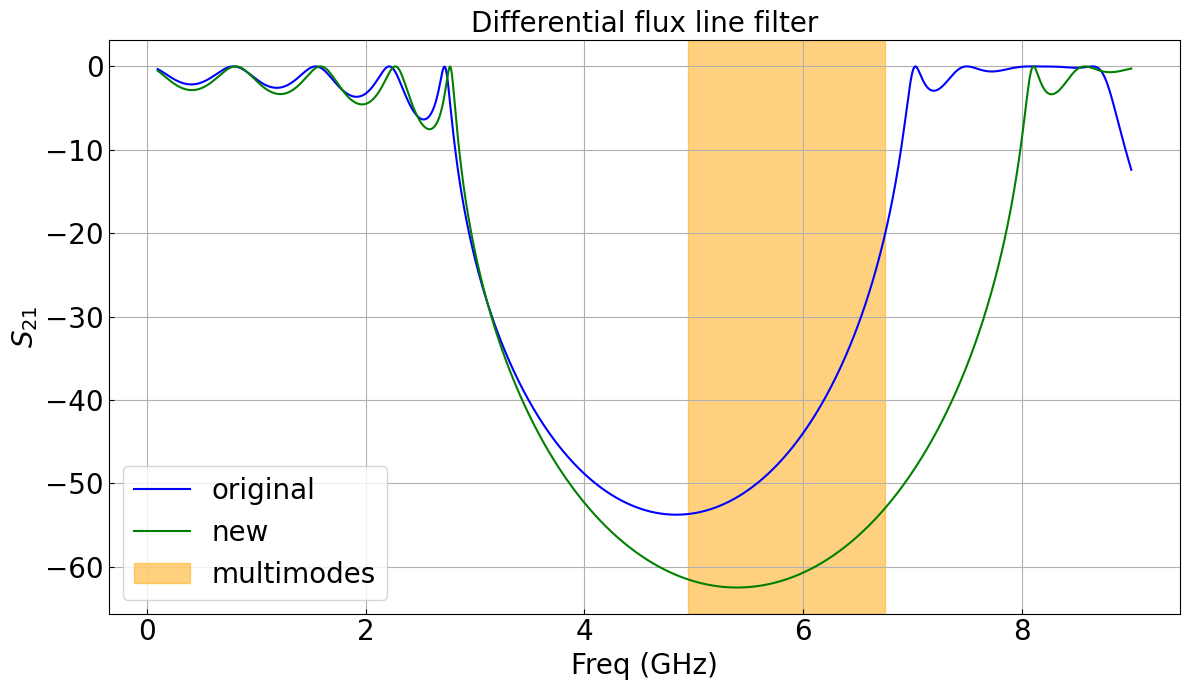

In [49]:
import matplotlib.transforms as mtransforms
fig, ax = plt.subplots(1, 1, figsize=(12,7))
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
plt.plot(f_list/1e9, S21, '-', color='blue', label='original')
plt.plot(f_list/1e9, S21_new, '-', color='green', label='new')
ax.set_xlabel(r'Freq (GHz)',size=20)
ax.set_ylabel(r'$S_{21}$',size=20)
ax.tick_params(labelsize=20)
plt.rcParams['xtick.direction'] = 'in'  
plt.rcParams['ytick.direction'] = 'in'
plt.title(r'Differential flux line filter',size=20)

ax.axvspan(cavity[0], cavity[1], alpha=0.5, color='orange', label='multimodes')
# ax.axvspan(7.3, 7.5, alpha=0.5, color='red', label='bad')
# plt.yscale('log')
# plt.ylim([3000,14000])
plt.grid()
plt.legend(fontsize=20)
plt.tight_layout()

Effect of Tuning Parameters: 
1. Increasing high impedance length reduces attebnuation but moves band rightwards
2. Increasing low impedance length introduces more bands

In [50]:

h = 500*1e-6
w_lo = 2.55*1e-3*0.95
s_lo = 5*1e-6
length_lo = 5.5*1e-3
w_hi = 5*1e-6
s_hi = 5*1e-6
length_hi = 5.5*1e-3
er = 11.1
z0 = 50
zlo = Zco(er, w_lo, s_lo, h)
zhi = Zco(er, w_hi, s_hi, h)
erlo = ero(er, w_lo, w_lo, h)
erhi = ero(er, w_hi, w_hi, h)

# zhi = 138.45   # from online calculator
# zlo = 22.91

vlo = 3*10**8/np.sqrt(erlo)
vhi = 3*10**8/np.sqrt(erhi)

# vlo = 1.2*10**8
# vhi = 1.2*10**8

nstep = 1000
f_list = np.linspace(0.1*10**9, 9*10**9, nstep)
S21_new = []
for f in f_list:
    ABCDlo = ABCD_HL(zlo, f, length_lo, vlo)
    ABCDhi = ABCD_HL(zhi, f, length_hi, vhi)
    ABCD = ABCDhi*ABCDlo*ABCDhi*ABCDlo*ABCDhi*ABCDlo*ABCDhi*ABCDlo*ABCDhi*ABCDlo*ABCDhi
    ss = 2/(ABCD[0,0]+ABCD[0,1]/z0+ABCD[1,0]*z0+ABCD[1,1])
    S21_new.append(10*np.log10(abs(ss*ss)))

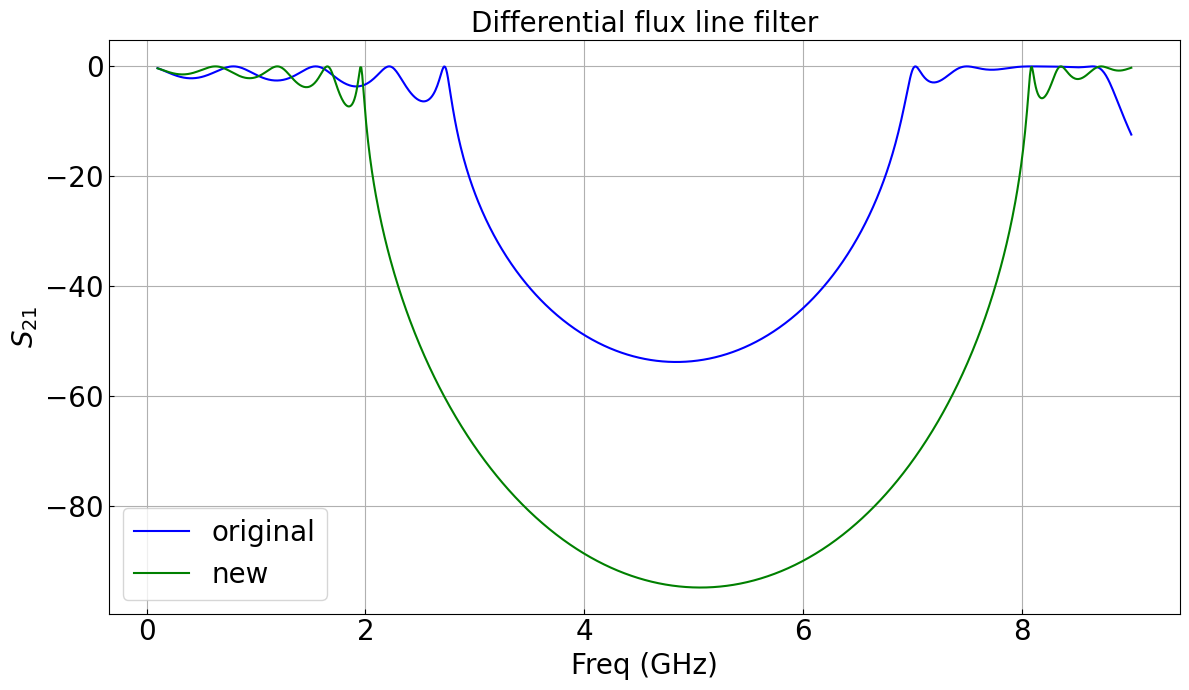

In [51]:
import matplotlib.transforms as mtransforms
fig, ax = plt.subplots(1, 1, figsize=(12,7))
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
plt.plot(f_list/1e9, S21, '-', color='blue', label='original')
plt.plot(f_list/1e9, S21_new, '-', color='green', label='new')
ax.set_xlabel(r'Freq (GHz)',size=20)
ax.set_ylabel(r'$S_{21}$',size=20)
ax.tick_params(labelsize=20)
plt.rcParams['xtick.direction'] = 'in'  
plt.rcParams['ytick.direction'] = 'in'
plt.title(r'Differential flux line filter',size=20)
# plt.yscale('log')
# plt.ylim([3000,14000])
plt.grid()
plt.legend(fontsize=20)
plt.tight_layout()

In [52]:

h = 500*1e-6
w_lo = 2.7*1e-3
s_lo = 2*1e-6
length_lo = 4.7*1e-3
w_hi = 2*1e-6
s_hi = 2*1e-6
length_hi = 4.888*1e-3
er = 11.1
z0 = 50
zlo = Zco(er, w_lo, s_lo, h)
zhi = Zco(er, w_hi, s_hi, h)
erlo = ero(er, w_lo, w_lo, h)
erhi = ero(er, w_hi, w_hi, h)

# zhi = 138.45   # from online calculator
# zlo = 22.91

vlo = 3*10**8/np.sqrt(erlo)
vhi = 3*10**8/np.sqrt(erhi)

# vlo = 1.2*10**8
# vhi = 1.2*10**8

nstep = 1000
f_list = np.linspace(0.01*10**9, 10*10**9, nstep)
S21_new = []
for f in f_list:
    ABCDlo = ABCD_HL(zlo, f, length_lo, vlo)
    ABCDhi = ABCD_HL(zhi, f, length_hi, vhi)
    ABCD = ABCDlo*ABCDhi*ABCDlo*ABCDhi*ABCDlo*ABCDhi*ABCDlo*ABCDhi*ABCDlo*ABCDhi*ABCDlo*ABCDhi*ABCDlo
    ss = 2/(ABCD[0,0]+ABCD[0,1]/z0+ABCD[1,0]*z0+ABCD[1,1])
    S21_new.append(10*np.log10(abs(ss*ss)))

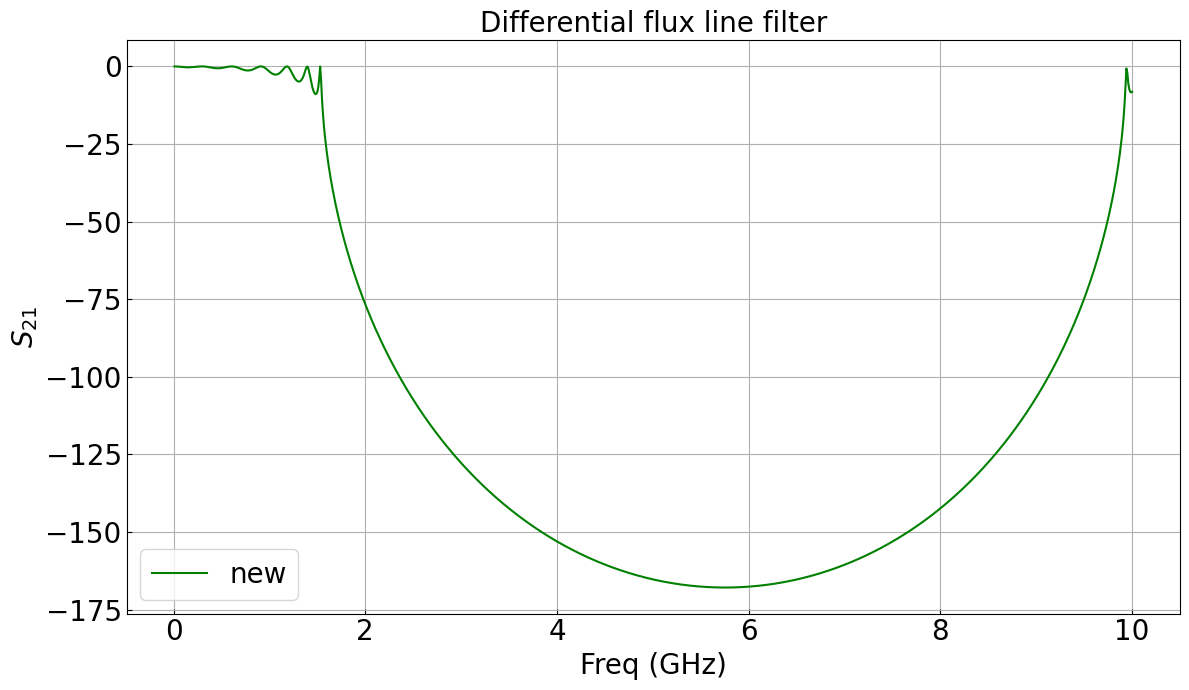

In [53]:
import matplotlib.transforms as mtransforms
fig, ax = plt.subplots(1, 1, figsize=(12,7))
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
# plt.plot(f_list/1e9, S21, '-', color='blue', label='original')
plt.plot(f_list/1e9, S21_new, '-', color='green', label='new')
ax.set_xlabel(r'Freq (GHz)',size=20)
ax.set_ylabel(r'$S_{21}$',size=20)
ax.tick_params(labelsize=20)
plt.rcParams['xtick.direction'] = 'in'  
plt.rcParams['ytick.direction'] = 'in'
plt.title(r'Differential flux line filter',size=20)
# plt.yscale('log')
# plt.ylim([3000,14000])
plt.grid()
plt.legend(fontsize=20)
plt.tight_layout()

# Effective Dielectric constants

In [54]:
def e_re_suspended(W = 1, h1 = 1, h2 = 3, eps = 11.5 ): 
    '''
    Suspended dielectric constant from hong
    '''
    a = ( 0.8621 - 0.1251 * np.log(h1/h2))**4
    b = (0.4986 - 0.1397* np.log(h1/h2))**4

    inside = 1 + (h1/h2) * (a - b * np.log(W/h2) )* (1/np.sqrt(eps) - 1)

    return np.square(1/inside )

Text(0, 0.5, 'Effective Dielectric constant of suspended microstrip')

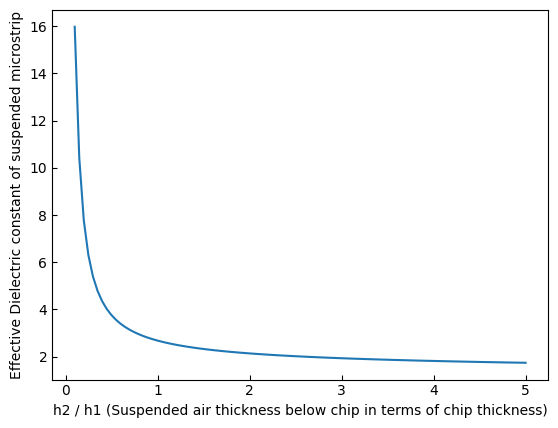

In [55]:
h2s = np.linspace(0.1, 5 , 100)
plt.plot(h2s, e_re_suspended(h2 = h2s)) 
plt.xlabel('h2 / h1 (Suspended air thickness below chip in terms of chip thickness)')
plt.ylabel('Effective Dielectric constant of suspended microstrip')

# Suppressing resonances of CPS

In [56]:
def ABCD_inductor(omega, L): 
    A = 1 
    B = 1.0j * omega * L 
    C = 0 
    D = 1
    return np.matrix([[A, B], [C, D]])

def ABCD_capacitor(omega, Cap): 
    A = 1 
    B = 0
    C = 1.0j * omega * Cap 
    D = 1
    return np.matrix([[A, B], [C, D]])

def ABCD_LC_two_port(omega, L , Cap): 
    '''
    Lc circuit on top line, ground on bottom
    '''
    A = 1 
    B = 1 / (1.0j * omega * Cap + 1/(1.0j * omega * L))
    C = 0
    D = 1
    return np.matrix([[A, B], [C, D]])


def ABCD_trx(omega, l , v , Z0): 
    '''
    Transmission line 
    '''
    phi = omega * l / v
    
    A = np.cos(phi)
    B = 1.0j * Z0 * np.sin(phi)
    C = 1.0j * (1/Z0) * np.sin(phi)
    D = A
    return np.matrix([[A, B], [C, D]])

## LC Circuit

In [57]:
L = 1 
omega = 2* np.pi * 5e+9 


Cap = 1/ (L*omega**2)
f_list = np.linspace(0.1*10**9, 20*10**9, nstep)
S21 = []
for f in f_list:
    
    ABCD = ABCD_LC_two_port(f * 2 * np.pi, L , Cap)
    ss = 2/(ABCD[0,0]+ABCD[0,1]/z0+ABCD[1,0]*z0+ABCD[1,1])
    S21.append(10*np.log10(abs(ss*ss)))

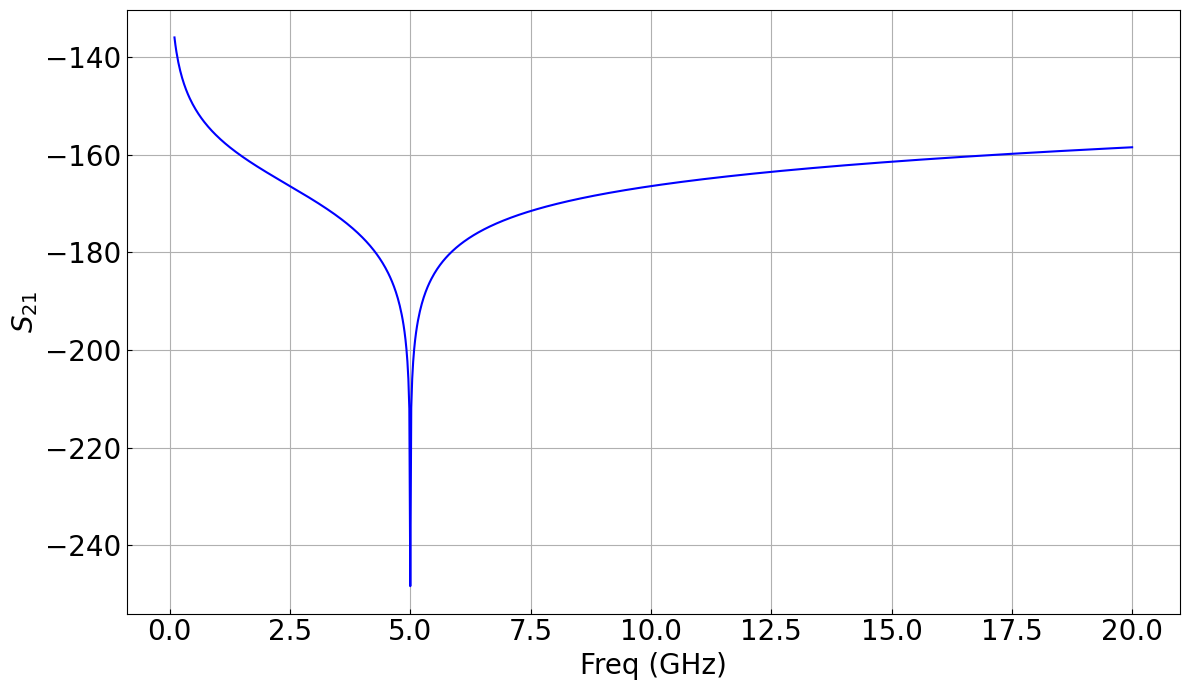

In [58]:
import matplotlib.transforms as mtransforms
fig, ax = plt.subplots(1, 1, figsize=(12,7))

plt.plot(f_list/1e9, S21, '-', color='blue')

ax.set_xlabel(r'Freq (GHz)',size=20)
ax.set_ylabel(r'$S_{21}$',size=20)
ax.tick_params(labelsize=20)
plt.rcParams['xtick.direction'] = 'in'  
plt.rcParams['ytick.direction'] = 'in'
#plt.yscale('log')
# plt.ylim([3000,14000])
plt.grid()
#plt.legend(fontsize=20)
plt.tight_layout()

## Transmission Line + LC Circuit

In [59]:
L = 1 
omega = 2* np.pi * 5e+9 
angle = 1*np.pi/2
v =1 
z0 = 50

l = angle/omega
Cap = 1/ (L*omega**2)
f_list = np.linspace(0.1*10**9, 20*10**9, nstep)
S21_ = []
S11_ = []
for f in f_list:
    
    ABCD = ABCD_trx(f * 2 * np.pi, l , v , z0) * ABCD_LC_two_port(f * 2 * np.pi, L , Cap)
    #ABCD = ABCD_LC_two_port(f * 2 * np.pi, L , Cap)
    s2 = 2/(ABCD[0,0]+ABCD[0,1]/z0+ABCD[1,0]*z0+ABCD[1,1])
    s1 = (ABCD[0,0] +ABCD[0,1]/z0 - ABCD[1,0]*z0 - ABCD[1,1] ) #/ (ABCD[0,0]+ABCD[0,1]/z0+ABCD[1,0]*z0+ABCD[1,1])
    S21_.append(10*np.log10(abs(s2*s2)))
    S11_.append(10*np.log10(abs(s1*s1)))

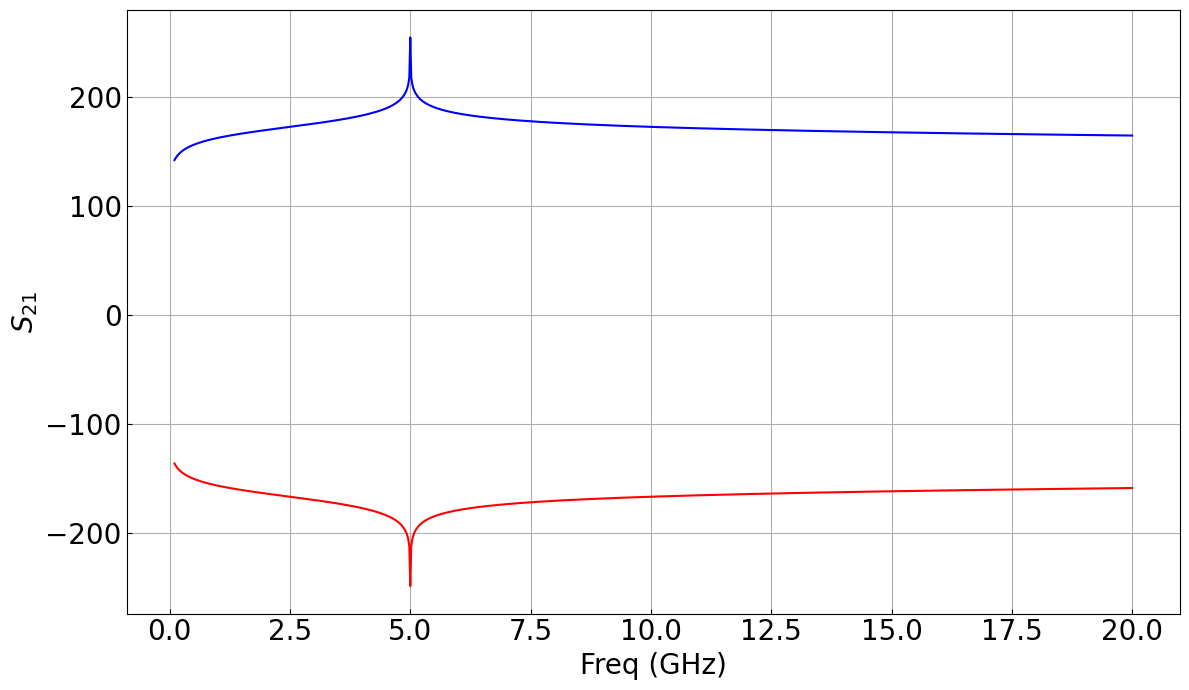

In [60]:
import matplotlib.transforms as mtransforms
fig, ax = plt.subplots(1, 1, figsize=(12,7))

plt.plot(f_list/1e9, S11_, '-', color='blue', label = 'S11')
plt.plot(f_list/1e9, S21_, '-', color='red', label = 'S21')

ax.set_xlabel(r'Freq (GHz)',size=20)
ax.set_ylabel(r'$S_{21}$',size=20)
ax.tick_params(labelsize=20)
plt.rcParams['xtick.direction'] = 'in'  
plt.rcParams['ytick.direction'] = 'in'
#plt.yscale('log')
# plt.ylim([3000,14000])
plt.grid()
#plt.legend(fontsize=20)
plt.tight_layout()

## Transmssion Line Impedance mismatch

In [71]:
L = 1 
omega = 2* np.pi * 5e+9 
#angle = 1*np.pi/2
v =2e+8
z0 = 50

l = np.pi*v/omega
#Cap = 1/ (L*omega**2)
f_list = np.linspace(0.1*10**9, 20*10**9, 1000)
S21_ = []
S11_ = []
for f in f_list:
    
    ABCD = ABCD_trx(f * 2 * np.pi, l , v , z0) #* ABCD_LC_two_port(f * 2 * np.pi, L , Cap)
    #ABCD = ABCD_LC_two_port(f * 2 * np.pi, L , Cap)
    s2 = 2/(ABCD[0,0]+ABCD[0,1]/z0+ABCD[1,0]*z0+ABCD[1,1])
    s1 = (ABCD[0,0] +ABCD[0,1]/z0 - ABCD[1,0]*z0 - ABCD[1,1] ) #/ (ABCD[0,0]+ABCD[0,1]/z0+ABCD[1,0]*z0+ABCD[1,1])
    S21_.append(10*np.log10(abs(s2*s2)))
    S11_.append(10*np.log10(abs(s1*s1)))

C:\Users\Tanay\AppData\Local\Temp\ipykernel_12324\3749439540.py:19: RuntimeWarning: divide by zero encountered in log10
  S11_.append(10*np.log10(abs(s1*s1)))


In [72]:
l

0.02

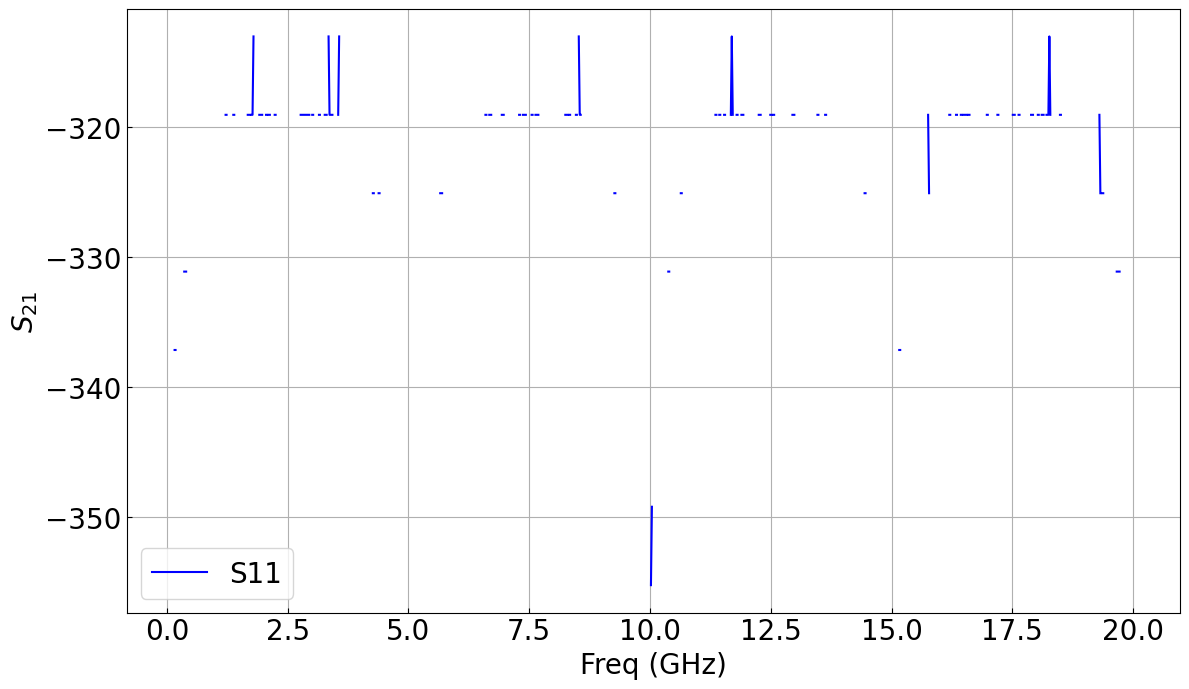

In [74]:
import matplotlib.transforms as mtransforms
fig, ax = plt.subplots(1, 1, figsize=(12,7))

plt.plot(f_list/1e9, S11_, '-', color='blue', label = 'S11')
#plt.plot(f_list/1e9, S21_, '-', color='red', label = 'S21')

ax.set_xlabel(r'Freq (GHz)',size=20)
ax.set_ylabel(r'$S_{21}$',size=20)
ax.tick_params(labelsize=20)
plt.rcParams['xtick.direction'] = 'in'  
plt.rcParams['ytick.direction'] = 'in'
#plt.yscale('log')
# plt.ylim([3000,14000])
plt.grid()
plt.legend(fontsize=20)
plt.tight_layout()